# Optimal Bayesian Experimental Design

R. D. McMichael 
rmcmichael@nist.gov  
National Institute of Standards and Technology  
Gaithersburg, MD  USA
March 29, 2019

## Introduction

This manual describes an implementation of optimal Bayesian experimental design methods.  These methods address routine measurements where data are fit to experimenal models in order to obtain model parameters.  The twin benefits of these methods  are reduced uncertainty with fewer required measurements.  These methods are therefore most beneficial in measurements where measurments are expensive in terms of money, time, risk, labor and/or discomfort.  The price for these benefits lies in the complexity of automating such measuremnts and in the computational load required.  It is the goal of this package to assist potential users in overcoming at least the programming hurdles.

Optimal Bayesian experimental design is not new, at least not in the statistics community.  A review paper from 1995 by [Kathryn Chaloner and Isabella Verinelli](https://projecteuclid.org/euclid.ss/1177009939) reveals that the basic methods had been worked out in preceding decades.  The methods implemented here closely follow [Xun Huan and Youssef M. Marzouk](http://dx.doi.org/10.1016/j.jcp.2012.08.013) which emphasizes simulation-based experimental design.  Optimal Bayesian experimental design is also an active area of research

There are at least three important factors that encourage application of these methods today.  First, the availability of flexible, modular (package friendly?) computer languages such as Python.  Second, availability of cheap computational power.   Most of all though, an increased awareness of the benefits of code sharing and reuse is growing in scientific communities, and the sharing is facilitated by websites such as sourceforge, bitbucket and github.

### Philosophy and attitude

> If it sounds good, it is good
>> Duke Ellington

The goals of this package are quite modest: To adapt some of the developments in optimal Bayeseian experimental design research for practical use in laboratory settings.

- If its a struggle to use, it can't run good.
- If its to full of technical jargon to understand, it can't run good
- If the user finds it useful, it runs good.
- If it runs good, it is good.

### Requirements for users

It's not zero work to get this software up and running.  Here's what a user will need to supply to get started.

1. An experiment that yields measurement results with uncertainty estimates. 
2. A model for the experiment - typically a function with parameters to be determined. 
3. A working knowledge of Python programming - enough to follow examples and program your own model.




## Theory of operation

Before diving into the statistical details lets take a short detour.  Suppose we have a simple programmable spectrometer that measures a peak in the $y$ vs. $x$ spectrum.  In our lab, the peak would be a magnetic resonance, but there are many examples of measured peaks in a broad range of sciences.  

Let's assume that our peak usually lies somewhere in the range 0 < $x$ < 10 and that the peak usually has an amplitude of 1 and a half-max width around 1.  A reasonable approach would be to run a few initial scans, averaging the scans long enough to get a signal to noise ratio of about 3.  People are naturally pretty good at filtering by eye, so if there are 10 samples within the width of the peak, we'll see a signal to noise of abou

[5.03956772] [[0.00181282]]


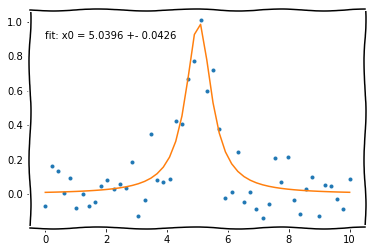

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.xkcd()

def llpeak(x, p): return 1/(4*(x-p)**2+1)    # model
x = np.linspace(0, 10, 50)                    # programmed x values
noise = np.random.randn(50)                   # sigma = 1 Gaussian noise
center_x = 3 + 4*np.random.rand()              # center somewhere between 3 and 7
data = llpeak(x, center_x) + noise/10  # suimulated data

popt, pcov = curve_fit(llpeak, x, data, [5,])
print(popt, pcov)
plt.plot(x, data, '.')
plt.plot(x, llpeak(x, popt), '-')
plt.text(0, .9, 'fit: x0 = {:6.4f} +- {:6.4f}'.format(popt[0], np.sqrt(pcov[0,0])))
plt.show()

The optimal Bayes experimental design method incorporates two main jobs, which we can describe as "learning fast" and "making good decisions"

## Learning fast

The learning process is a straightforward application of the well-known Bayesian inference method.  If that last sentence made perfect sense to you, feel free to skip ahead.  For the rest of us we'll start in the logical place, ~~at the beginning~~ in the middle.

We do measurements in order to learn things.  At the very beginning, before we start measuring, we may have some knowledge or experience, but we expect to have better information after we measure.  There are phenomena like drift that can spoil things, but in general, we expect to learn something from each measurement.  Next, we're going to look at how the knowledge gets better as a new measurment result is digested.  For that we need to use some technical language.

We'll express our knowledge of the set of model parameters $\theta$ as a probability distribution function $p(\theta)$.  If $p(\theta)$ is a broad distribution, then we really don't know the values very well, and if $p(\theta)$ is narrow, the uncertaintly is small.  When we get a measurement result $m$ at settings $x$, the results should have some influence on $p(\theta)$.  

So what's $m$, exactly? It's a package that includes experimental settings and measured values including uncertainty estimates.  This software assumes that your experiment yields mean values and standard deviations, which is a shorthand way of saying that the noise in your experiment follows a Gaussian distribution.

>If your measurements don't have uncertainty, you might be a redneck.  

When we make a new measurement $m$ we want to know the new probability distribution $p(\theta|m)$ after we have taken $m$ into account.  The vertical bar in the notation $p(\theta|m)$ indicates a conditional probablility, the distribution of $\theta$ values given $m$. Bayes theorem gives us
    $$ p(\theta|m) = \frac{p(m|\theta) p(\theta)}{p(m)}. $$
   
It's easy to write down Bayes theorem.  At least for me, the challenge is understanding what the symbols mean.  All of the terms here have special names.  The left side is the _posterior_ distribution, i.e. the distribution after we include $m$. Distribution $p(\theta)$ is the _prior_, representing what we knew about the parameters $\theta$ before the measurement. In the denominator, $p(m)$ is the _evidence_, but $m$ is a permanent record of numbers (for now), and its probability is a constant.  The term that we need to focus on, $p(m|\theta)$, is called the _likelihood_.  It's the probability of getting the particular combination of settings and results $m$ given different parameter values.  

It's worthwhile to take a little time to get aquainted with the _likelihood_, so Let's look at the likelihood's arguments first.  Note that the measurment $m$ are numbers that came from the instruments, so $m$ is fixed.  But the parameters $\theta$ are variable, so $P(m|\theta)$ behaves like a function of $\theta$.  A particular measuremnt result $m$ is more likely for some parameters than for others. So the likelihood answers this question: for different parameters $\theta$, what's the probability that our measurment will yield the value $m$?     

In constructing $P(m|a)$, we're answering a question about how we expect our system to behave, expressed as a probability.  We take the case where our system has an explicit model
    $$ P(y) = f(x, a) $$,
which says that given experimental settings $x$ and sample parameters $a$, we know our system well enough to predict the distribution of measurement results $y$ as $P(y)$.  If our experiment demonstrates Gaussian noise, we can write
    $$ P(y) \propto \exp[-(y-\bar{y}(x, a))^2/2\sigma^2 ]$$
    
Now we know how to update our "knowledge" of parameters $a$ expressed as a probability distribution $P(a)$.
1. Collect measurement data including settings, $x$, measurement values $y$ and measurement uncertainties $\sigma$.
2. For all values of $a$ calculate the model's prediction of the mean measurment result, $\bar{y}(x, a)$
3. For all values of $a$ either
   - multiply $P(a)$ by the likelihood $\exp[-(y-\bar{y}(x, a))^2/2\sigma^2 ]$ or
   - add $\ln P(a)$ to  $-(y-\bar{y}(x, a))^2/2\sigma^2$
4. Normalize

We just made several important assumptions:
 - That a known function of settings $x$ and unknown parameters $a$ describes our experimenal results
 - that the noise in our measurement is Gaussian with standard deviation $\sigma$.  
On one hand we have to admit that these assumptions don't allow us to address all important cases.  On the other hand, these are the same assumptions we make in doing least-squares curve fitting.


## Making good decisions

The next important job in the process is figuring out the settings to use for the next measurement.  The hard part is defining  what it is that we're trying to accomplish in mathematical terms.   At least in part, we want to make the parameter probability distribution $p(\theta)$ narrow.  We might also want to minimize cost or time spent in situations where some setttings are more expensive.  We might have more than one purpose for the measurements, for example to fit a model, and also to demonstrate the fidelity of the model.

The challenge, then is to develop a _utility function_ $U(x)$ that helps us to predict and compare the relative benefit/cost ratio of different possible experimental settings $x$.

First, an appeal to intuition.  Our system model describes a connection between parameter values $a$ and measurement results $y$.  If the model parameters are allowed to wiggle, say by taking random draws from the parameter probability distribution,  the model output $y$ also wiggles.  They're connectded.  So if we want to constrain the parameter values it would do the most good to "pin down" the measurement at the settings $x$ where the predicted variations in $y$ are the largest, i.e. most strongly coupled to the parameters $a$.  To translate such a qualitative argument into code, a good place to start is to clarify what we mean by "doing the most good" in refining our parameter distribution $p(\theta)$.

When we determine model parameters, usually the goal is to get results with small uncertainty.  But here we're thinking in terms of a distribution $p(\theta)$.  Information theory gives us information entropy as a way to quantify the sharpness of a probability distribution.  The information entropy of a probability distribution $p(a)$ is defined as  
 $$ E = -\int da\; p(a)\; \ln[p(a)] $$  
Note that the integrand is zero for both $p(a) = 1$ and $p(a)=0$.  It's the intermediate values encountered in a spread-out distribution where the information entropy accumulates.  For common distributions, like rectangular or Gaussian, that have characteristic widths $w$ the entropy goes like $\ln(w) + C$.

We adopt the information entropy as our measure of $p(\theta)$ sharpness, and that makes it possible to estimate how much $E$(posterior) - $E$(prior) we might get for predicted measurement values $y$ at different settings $x$.  Actually, the statisticians use something slightly different called the Kulback-Liebler divergence. 
$$ D^{KL} = \int\int d\theta dy\; p(\theta |y,x)\ln \left[ \frac{p(\theta | y,x)}{p(\theta)}\right] $$  
Here, we're using $y,x$ to denote predicted measurements at potential settings $x$ instead of the $m$ we used for a completed measurement in the learning section above.

The result for each value of $x$ is the difference between two information entropy values: the entropy of the distribution of $y$ values including different values of $\theta$ and measurement noise, discounted by the entropy of the measurement noise distribution.

$$ U(x) \propto \int dy\; $$  
There's a language problem that can be confusing when measurment and information theory collide.  We make measurements to get information about stuff, right?  Well, in information theory language, it's just the opposite.  The information content of a distribution reflects the variety of values that you get when you take random draws from that distribution.  A very narrow distribution might give you essentially the same value every time, and from an information theory point of view, that would amount to no information.  From a measurment perspective, though, a very narrow distribution indicates very good information.  It just goes to show:  _No information is good information.  QED_




If we hold the measurement settings in the model constant and let the parameter values vary, we would expect the model's $\bar{y}$ measurement predictions to vary, too.  And if $a$ varies according random draws from $p(\theta)$, we can accumulate modeled $\bar{y}$ values and approximate a distribution $p(\bar{y}|x)$

If we take the Kulback-Liebler divergence as a measure of the information entropy difference between the posterior and prior distributions, we
